In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from PIL import Image
import tensorflow as tf
import os
import pandas as pd
import numpy
import shutil

sys.path.append(os.path.abspath("./slim/"))
import slim

In [3]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
def randfloat(a, b):
    return rand.random() * (b - a) + a

def my_print(s):
    sys.stdout.write(s)
    sys.stdout.flush()

In [4]:
data_dir = "./data/arrows/input_col/"
save_dir = "./save_col/"
save_file_path = os.path.join(save_dir, "model.ckpt")
logs_dir = "./logs_col/"

create_dir(save_dir)
create_dir(logs_dir)

BATCH_SIZE = 32
IMAGE_SIZE = 128

In [5]:
def _create_fname_producers():
    lines = os.listdir(data_dir)    
    cnt = len(lines)
    p = 0.9
    train_cnt = int(cnt * p)
    my_print("Total: %i images, train: %i\n" % (cnt, train_cnt))
    train_lines = lines[:train_cnt]
    test_lines = lines[train_cnt:]
    return tf.train.string_input_producer(train_lines), tf.train.string_input_producer(test_lines)

def _read_image(fname):
    with tf.name_scope("read_image"):
        file_content = tf.read_file(tf.constant(data_dir) + fname)
        image3c = tf.cast(tf.image.decode_png(file_content, channels=3, dtype=tf.uint8), tf.float32)
        image1, image2 = tf.split(1, 2, image3c)
        image1.set_shape((IMAGE_SIZE, IMAGE_SIZE, 3))
        image2.set_shape((IMAGE_SIZE, IMAGE_SIZE, 3))
    return image1, image2

def _generate_batch(image1, image2, batch_size, min_after_dequeue):
    with tf.name_scope("generate_batch"):
        images1, images2 = tf.train.shuffle_batch([image1, image2], batch_size=batch_size / 2, 
                                                capacity=min_after_dequeue + batch_size * 4, 
                                                min_after_dequeue=min_after_dequeue,
                                                num_threads=5)

        images12 = tf.concat(0, [images1, images2])
        images21 = tf.concat(0, [images2, images1])
        labels12 = tf.concat(0, [tf.constant(1, tf.int64, [batch_size / 2]), 
                                 tf.constant(0, tf.int64, [batch_size / 2])])
    return images12, images21, labels12

def _producer_to_batch(queue, BATCH_SIZE, min_after_dequeue=5000):
    image1, image2 = _read_image(queue.dequeue())
    images1, images2, labels = _generate_batch(image1, image2, BATCH_SIZE,
                                               min_after_dequeue=min_after_dequeue)
    return images1, images2, labels
    
def get_data_batch(dual=True):
    train_queue, test_queue = _create_fname_producers()
    return _producer_to_batch(train_queue, BATCH_SIZE) + \
           _producer_to_batch(test_queue, BATCH_SIZE, BATCH_SIZE)

def dense_to_one_hot(label_batch, num_labels=2):
    with tf.name_scope("one_hot_encoder"):
        sparse_labels = tf.cast(tf.reshape(label_batch, [-1, 1]), tf.int32)
        derived_size = tf.shape(sparse_labels)[0]
        indices = tf.reshape(tf.range(0, derived_size, 1), [-1, 1])
        concated = tf.concat(1, [indices, sparse_labels])
        outshape = tf.concat(0, [tf.reshape(derived_size, [1]), tf.reshape(num_labels, [1])])
        labels = tf.sparse_to_dense(concated, outshape, 1.0, 0.0)
        labels = tf.cast(labels, tf.float32)
    return labels


In [6]:
def normalize_images(images1, images2):
        mean1 = tf.reduce_mean(images1, [1, 2, 3], True)
        mean1 = tf.tile(mean1, [1, IMAGE_SIZE, IMAGE_SIZE, 3])
        return images1 - mean1, images2 - mean1

def build_classifier(images1, images2, trainable=True):
    images1, images2 = normalize_images(images1, images2)
    images = tf.concat(3, [images1, images2])
    
    wd = 0.0005
#     if not trainable:
#         wd = None

    with slim.arg_scope([slim.ops.conv2d], stddev=0.01, weight_decay=wd, trainable=trainable):
        net = slim.ops.repeat_op(1, images, slim.ops.conv2d, 64, [3, 3], scope='conv1')
        net = slim.ops.max_pool(net, [2, 2], scope='pool1')
        net = slim.ops.repeat_op(1, net, slim.ops.conv2d, 128, [3, 3], scope='conv2')
        net = slim.ops.max_pool(net, [2, 2], scope='pool2')
        net = slim.ops.repeat_op(1, net, slim.ops.conv2d, 256, [3, 3], scope='conv3')
        net = slim.ops.max_pool(net, [2, 2], scope='pool3')
        net = slim.ops.repeat_op(1, net, slim.ops.conv2d, 512, [3, 3], scope='conv4')
        net = slim.ops.max_pool(net, [2, 2], scope='pool4')
        net = slim.ops.repeat_op(1, net, slim.ops.conv2d, 2, [3, 3], activation=None, scope='conv5')
        
        net = tf.reduce_mean(net, reduction_indices=[1, 2], name="reduce")
        net = tf.nn.softmax(net, name="softmax")
        
    return net
        
    

In [7]:
def build_loss(logits, labels):
    with tf.name_scope("cross_entropy"):
        labels = tf.cast(labels, tf.int64)
        dense_labels = dense_to_one_hot(labels)
        clipped_logits = tf.clip_by_value(logits, 1e-10, 100.0)
        cross_entropy = -dense_labels * tf.log(clipped_logits)
        cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')

    return cross_entropy_mean

def _add_loss_summaries(losses_list):
    loss_averages = tf.train.ExponentialMovingAverage(0.9, name='avg')
    loss_averages_op = loss_averages.apply(losses_list)
    for l in losses_list:
        tf.scalar_summary(l.op.name +' (raw)', l)
        tf.scalar_summary(l.op.name, loss_averages.average(l))

    return loss_averages_op

In [8]:
def build_train(loss_op, step, init_rate=0.01, decay_steps=6000):
    
    with tf.name_scope("train"):
        optimizer = tf.train.AdamOptimizer(init_rate)
        grads = optimizer.compute_gradients(loss_op)

        apply_gradient_op = optimizer.apply_gradients(grads, global_step=step)

        for var in tf.trainable_variables():
            tf.histogram_summary(var.op.name, var)

        for grad, var in grads:
            if grad:
                tf.histogram_summary(var.op.name + '/gradients', grad)

    return apply_gradient_op

In [9]:
def load(saver, sess):
    saver.restore(sess, save_file_path)
    my_print("Model restored.\n")
    
def save(saver, sess):
    save_path = saver.save(sess, save_file_path)
    my_print("Model saved in file: %s\n" % save_path)

def train_classifier(need_load, N=10000, init_rate=0.01):
    
    with tf.Graph().as_default() as g: 
        
        step = slim.variables.variable('step', [], tf.int32, tf.constant_initializer(0), trainable=False)
    
        images1_train, images2_train, labels_train, images1_test, images2_test, labels_test = get_data_batch()
        images1_ph = tf.placeholder(tf.float32, [BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3], "images1")
        images2_ph = tf.placeholder(tf.float32, [BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3], "images2")
        labels_ph = tf.placeholder(tf.int64, [BATCH_SIZE], "labels")
        answer_op = build_classifier(images1_ph, images2_ph, trainable=True)
        loss_op = build_loss(answer_op, labels_ph)
        losses_list = tf.get_collection('losses') + [loss_op]
        total_loss = tf.add_n(losses_list, name='total_loss')
        loss_summaries = _add_loss_summaries(losses_list + [total_loss])
        with tf.control_dependencies([loss_summaries]):
            train_op = build_train(total_loss, step, init_rate=init_rate)
        correct_prediction = tf.equal(tf.argmax(answer_op, 1), labels_ph)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        accuracy_summary = tf.scalar_summary("accuracy", accuracy)

        merged_summaries = tf.merge_all_summaries()

        init = tf.initialize_all_variables()

        sess = tf.Session(config=tf.ConfigProto(log_device_placement=False))
        saver = tf.train.Saver(var_list=tf.get_collection(slim.variables.VARIABLES_TO_RESTORE))
        coord = tf.train.Coordinator()
        writer = tf.train.SummaryWriter(logs_dir, sess.graph_def, flush_secs=30)

        sess.run(init)
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)

        try:

            if need_load:
                load(saver, sess)

            my_print("Starting...\n")

            for i in xrange(0, N):
                if i % 11 == 0:
                    im1, im2, lab = sess.run([images1_test, images2_test, labels_test])
                    feed = {
                        images1_ph : im1,
                        images2_ph : im2,
                        labels_ph : lab
                    }
                    result = sess.run([merged_summaries, accuracy, step], feed_dict=feed)
                    summary_str = result[0]
                    acc = result[1]
                    st = result[2]
#                     writer.add_summary(summary_str, st)
                    print("Accuracy on test at step %s: %s" % (st, acc))
                else:
                    im1, im2, lab = sess.run([images1_train, images2_train, labels_train])
                    feed = {
                        images1_ph : im1,
                        images2_ph : im2,
                        labels_ph : lab
                    }
                    result = sess.run([train_op, merged_summaries, accuracy, step], feed_dict=feed)
                    summary_str = result[1]
                    acc = result[2]
                    st = result[3]
                    if st % 10 == 0:
                        writer.add_summary(summary_str, st)
#                     print("Accuracy at step %s: %s" % (st, acc))
                    

                if i % 100 == 0:
                    save(saver, sess)
        finally:
            coord.request_stop()
            coord.join(threads)


In [10]:
# train_classifier(need_load=True, N=1000000, init_rate=0.0001)

In [ ]:
gen_logs_dir = "./logs_col_gen/"

def predict_image(fname, N=10000000, init_rate=0.001):
    
    with tf.Graph().as_default() as g: 
        
        step = slim.variables.variable('step_pred', [], tf.int32, tf.constant_initializer(0), 
                                            trainable=False, restore=False)
        
        image = imread(data_dir + fname, 'RGB')[:, :IMAGE_SIZE, :]
        imsave('in.png', image)
        imshow(image)
        show()
        image = np.reshape(image, (1, IMAGE_SIZE, IMAGE_SIZE, 3))
        image1 = tf.constant(image, tf.float32, name='image1')
        image2 = tf.Variable(image1, trainable=True, name='image2')
#         image2 = tf.Variable(tf.random_uniform([1, IMAGE_SIZE, IMAGE_SIZE, 3], 0, 255), 
#                     trainable=True, name='image2')
        
        tf.image_summary("image1", image1)
        tf.image_summary("image2", image2)
    
        images12 = tf.concat(0, [image1, image2], 'images1')
        images21 = tf.concat(0, [image2, image1], 'images2')
        labels = tf.constant([1, 0], tf.int64, [2], "labels")
        
        answer_op = build_classifier(images12, images21, trainable=False)
    
        loss_op = build_loss(answer_op, labels)
        losses_list = [
            loss_op 
#             , slim.losses.l2_loss(image1 - image2, weight=1e-7)
        ]
        total_loss = tf.add_n(losses_list, name='total_loss')
        loss_summaries = _add_loss_summaries(losses_list + [total_loss])
    
        with tf.control_dependencies([loss_summaries]):
            train_op = build_train(total_loss, step, init_rate=init_rate)
    
        correct_prediction = tf.equal(tf.argmax(answer_op, 1), labels)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        accuracy_summary = tf.scalar_summary("accuracy", accuracy)

        merged_summaries = tf.merge_all_summaries()

        init = tf.initialize_all_variables()

        sess = tf.Session(config=tf.ConfigProto(log_device_placement=False))
        saver = tf.train.Saver(var_list=tf.get_collection(slim.variables.VARIABLES_TO_RESTORE))
        coord = tf.train.Coordinator()
        writer = tf.train.SummaryWriter(gen_logs_dir, sess.graph_def, flush_secs=30)

        sess.run(init)


        load(saver, sess)

        my_print("Starting...\n")

        for i in xrange(0, N):
            result = sess.run([train_op, merged_summaries, accuracy, step, image2])
            summary_str = result[1]
            acc = result[2]
            st = result[3]
            img = result[4]
            writer.add_summary(summary_str, st)
#                     print("Accuracy at step %s: %s" % (st, acc))


            if i % 1000 == 0:
                print i
                out = np.clip(img[0], 0, 255).astype(np.uint8)
                imsave('out.png', out)
#                     save(saver, sess)


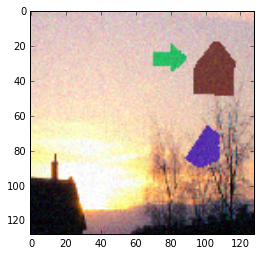

Model restored.
Starting...
0
1000
2000
3000


In [ ]:
predict_image("543.png", init_rate=.01)